# Diffusion and Oxidant Concentration

This plots the change in several different aerosol properties as a function of diffusion coefficient and oxidant concentration. The diffusion coefficient is increased by an order of magnitude for each model scenario. The number after D indicates the negative base 10 logarithm of the diffusion coefficient for that scenario. The oxidant concentration is indicated by the condition where ft corresponds to flow tube ($5.04 \times 10^{10}$ molecules cm$^{-3}$), cfstr corresponds to continuous flow stir reactor ($5.04 \times 10^{8}$ molecules cm$^{-3}$), and day corresponds to daytime conditions ($5 \times 10^{6}$ molecules cm$^{-3}$). To run this notebook, the data must first be processed from XML files by running diffusion_processing.py. See that file or Postprocessing.ipynb for more information about the processing of the data.

In [1]:
%%HTML 
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [1]:
# Import modules

import warnings
warnings.filterwarnings('ignore')
import os

import StackSim
import numpy as np
import pandas as pd
from matplotlib import ticker
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import natsort



In [4]:
# Create platform independent subdirectory

subdir = os.path.join(os.path.curdir, "dif_summary")

diffusion = dict()

diffusion["overall"] = ["D10", "D11", "D12", "D13", "D14", "D15", "D16", "D17", "D18"]
diffusion["ft"] = ["D11", "D12", "D13", "D14", "D15", "D16", "D17", "D18"]
diffusion["cfstr"] = ["D13", "D14", "D15", "D16", "D17", "D18"]
diffusion["day"] = ["D15", "D16", "D17", "D18"]


condition = ["ft", "cfstr", "day"]

D_string_conv = {"D10" : 1E-10, "D11" : 1E-11, "D12" : 1E-12, "D13" : 1E-13,
                "D14" : 1E-14, "D15" : 1E-15, "D16" : 1E-16,
                "D17" : 1E-17, "D18" : 8.39E-19}

D_string_format = {"D10" : r"$10^{-10}$", "D11" : r"$10^{-11}$", "D12" : r"$10^{-12}$",
                   "D13" : r"$10^{-13}$", "D14" : r"$10^{-14}$", "D15" : r"$10^{-15}$",
                   "D16" : r"$10^{-16}$", "D17" : r"$10^{-17}$", 
                   "D18" : r"$8.39 \times 10^{-19}$"}

cond_string_conv = {"ft" : r"[OH] = $5.04 \times 10^{10}$", 
                    "cfstr" : r"[OH] = $5.04 \times 10^{8}$",
                    "day" : r"[OH] = $5 \times 10^{6}$"}

# Generate dictionary of filename strings

files = dict()

for cond in condition:
    for coefficient in diffusion["overall"]:
        if coefficient in diffusion[cond]:
            filename = cond+"_"+coefficient+".xlsx"
        else:
            filename = cond+"_SC.xlsx"
        files[cond+"_"+coefficient] = filename




## Simulation data plots

After loading the data, plots showing several different variables at different oxidant and diffusion coefficients are generated.

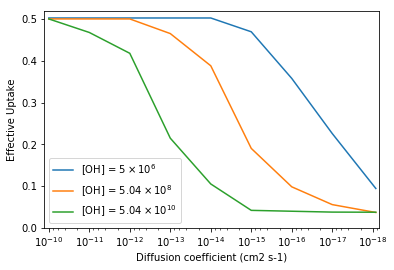

In [6]:
%matplotlib inline

diff_string = 'Diffusion coefficient (cm2 s-1)'
uptake_string = 'Effective Uptake'



uptake_data = dict()

fig, ax = plt.subplots(1)

for cond in reversed(condition):
    coef = np.array([])
    uptake = np.array([])
    
    # Get uptake coefficient from each file
    for D in diffusion["overall"]:
        with pd.ExcelFile(os.path.join(subdir, files[cond+"_"+D])) as xlsx:
            df = pd.read_excel(xlsx, 'model summary')
        coef = np.append(coef, D_string_conv[D])
        uptake = np.append(uptake, df[uptake_string].iloc[0])
    
    # Put in data frame
    uptake_data[cond] = pd.DataFrame({diff_string : coef, 
                                      cond_string_conv[cond] : uptake})
    
    # Plot data
    uptake_data[cond].plot(x = diff_string, y = cond_string_conv[cond],
                          ax = ax, logx=True, xlim=(1.3E-10, 7E-19),
                          ylim=(0, 0.51))

ax.set_xlim([1.3E-10, 7E-19])
ax.set_ylim([0, 0.52])
ax.set_xlabel(diff_string)
ax.set_ylabel(uptake_string)

fig.savefig(os.path.join(subdir, 'effuptake.png'),
            fmt='png', dpi=300, bbox_inches='tight')

    

In [7]:
# Load data to be graphed below.

ScenarioData = dict()
OC_contours = dict()
Tri_contours = dict()
Peroxy_contours = dict()

for file in files.keys():
    with pd.ExcelFile(os.path.join(subdir, files[file])) as xlsx:
        ScenarioData[file] = pd.read_excel(xlsx, 'average data', header=0)
        Tri_contours[file] = pd.read_excel(xlsx, 'Triacontane (normalized)',
                                         skiprows=0, index_col=0, header=1)
        OC_contours[file] = pd.read_excel(xlsx, 'O to C ratio',
                                        skipows=0, index_col=0, header=1)
        Peroxy_contours[file] = pd.read_excel(xlsx, 'Peroxy radicals',
                                            skiprows=0, index_col=0, header=1)
        

        
    

## Model scenario comparison

To summarize this large data set, several average values are placed in a panel plot comparing diffusion coefficient and oxidant concentration.

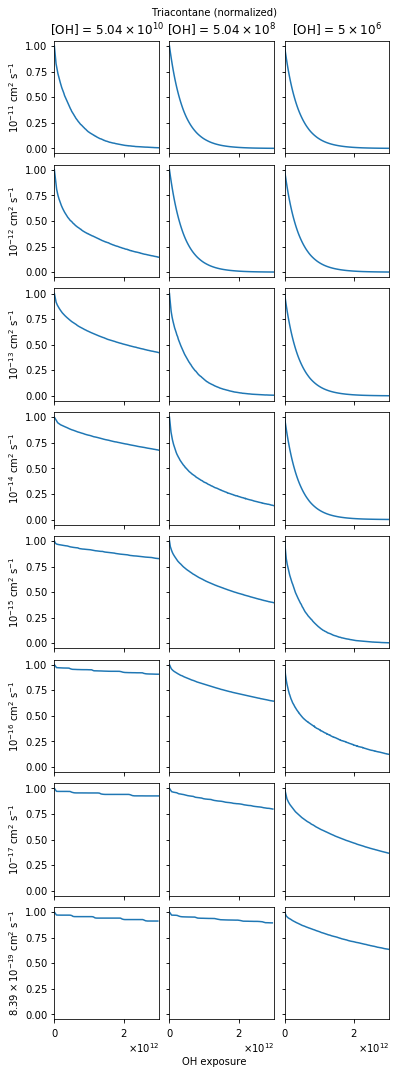

In [8]:
%matplotlib inline

# Triacontane decay comparison

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 18))

tri_string = "Triacontane (normalized)"

plt.figtext(0.35, 0.90, tri_string)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.figtext(0.42, 0.09, "OH exposure")

i = 0
for cond in condition:
    j = 0
    for D in diffusion["ft"]:
        ScenarioData[cond+"_"+D].plot(x = 'OH exposure', y = tri_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
fig.savefig(os.path.join(subdir, 'triacontane.png'),
            fmt='png', dpi=300, bbox_inches='tight')

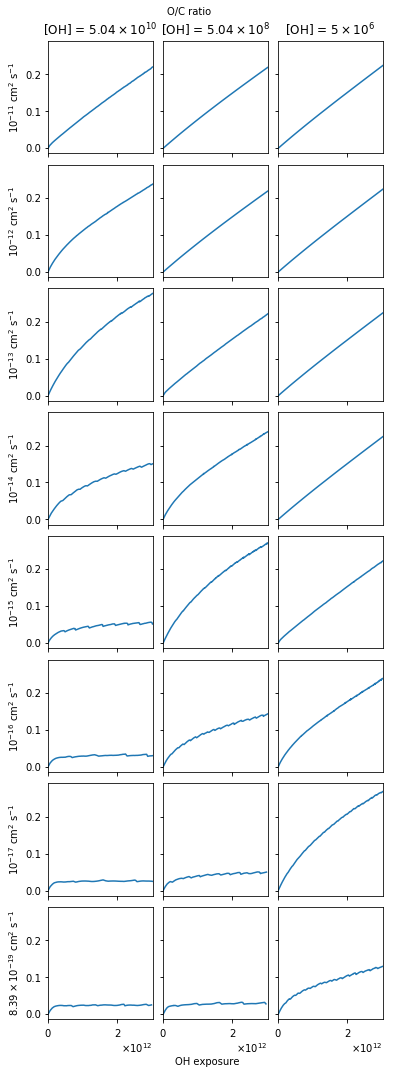

In [53]:
%matplotlib inline

# O/C ratio comparison

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 18))

OC_string = "O/C ratio"

plt.figtext(0.4, 0.90, OC_string)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.figtext(0.42, 0.09, "OH exposure")

i = 0
for cond in condition:
    j = 0
    for D in diffusion["ft"]:
        ScenarioData[cond+"_"+D].plot(x = 'OH exposure', y = OC_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
fig.savefig(os.path.join(subdir, 'O to C ratio.png'),
            fmt='png', dpi=300, bbox_inches='tight')

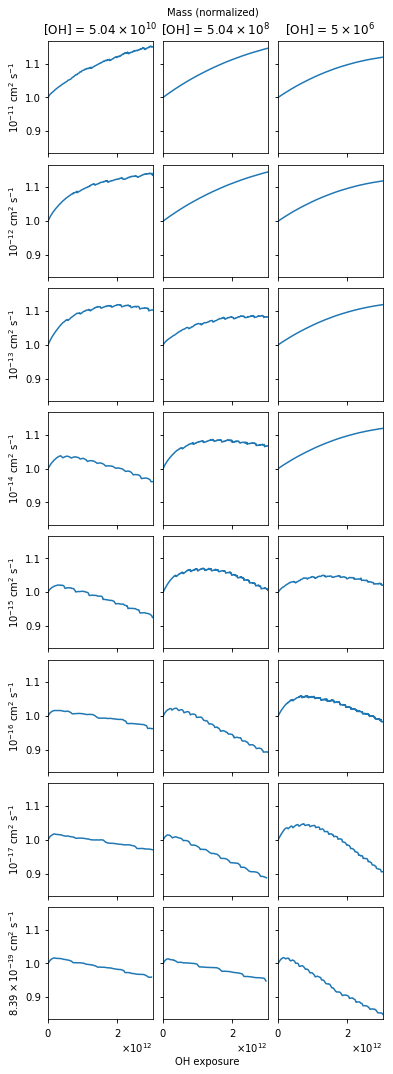

In [54]:
%matplotlib inline

# Mass comparison

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 18))

mass_string = "Mass (normalized)"

plt.figtext(0.4, 0.90, mass_string)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.figtext(0.42, 0.09, "OH exposure")

i = 0
for cond in condition:
    j = 0
    for D in diffusion["ft"]:
        ScenarioData[cond+"_"+D].plot(x = 'OH exposure', y = mass_string,
                                      ax = axes[j, i], legend=False)
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
fig.savefig(os.path.join(subdir, 'mass.png'),
            fmt='png', dpi=300, bbox_inches='tight')

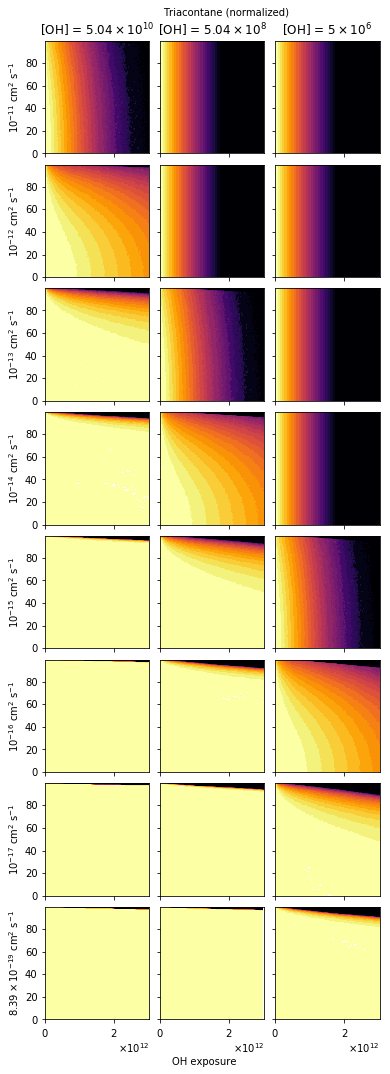

In [16]:
%matplotlib inline

# Set up color map levels

N_levels = 26
  
levels = np.array([0])
levels = np.append(levels, np.logspace(-4, 0, num=N_levels, base = np.e))
labels = np.logspace(-2, 0, num=6, base = 10)
    
cmap = mpl.cm.get_cmap('inferno', N_levels)
    
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 18))

plt.figtext(0.4, 0.90, "Triacontane (normalized)")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.figtext(0.42, 0.09, "OH exposure")



i = 0
for cond in condition:
    j = 0
    for D in diffusion["ft"]:
        data = Tri_contours[cond+"_"+D]
        axes[j, i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
axes[0,0].set_xlim([0,3.02E12])

fig.savefig(os.path.join(subdir, 'tri_contours.png'),
            fmt='png', dpi=300, bbox_inches='tight')



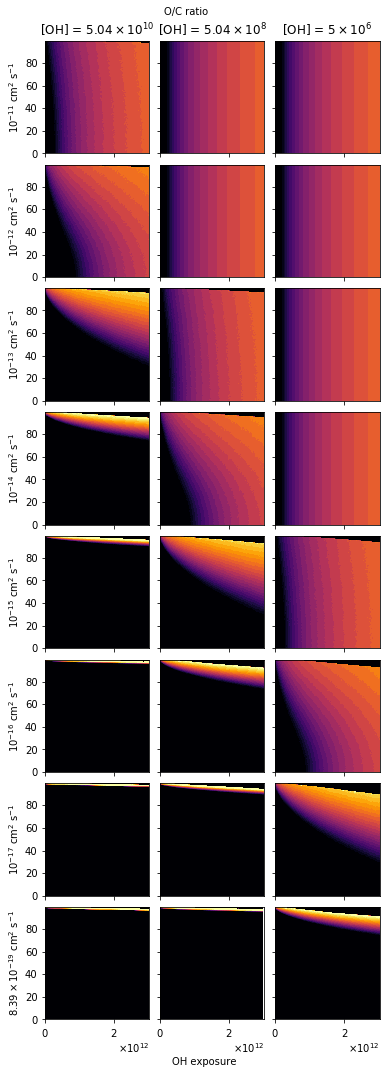

In [17]:
%matplotlib inline

# Set up color map levels

N_levels = 26
  
levels = np.array([0])
levels = np.append(levels, np.logspace(-4, 0, num=N_levels, base = np.e))
labels = np.logspace(-2, 0, num=6, base = 10)
    
cmap = mpl.cm.get_cmap('inferno', N_levels)
    
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 18))

plt.figtext(0.4, 0.90, "O/C ratio")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.figtext(0.42, 0.09, "OH exposure")



i = 0
for cond in condition:
    j = 0
    for D in diffusion["ft"]:
        data = OC_contours[cond+"_"+D]
        axes[j, i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
axes[0,0].set_xlim([0,3.02E12])

fig.savefig(os.path.join(subdir, 'ocratio_contours.png'),
            fmt='png', dpi=300, bbox_inches='tight')

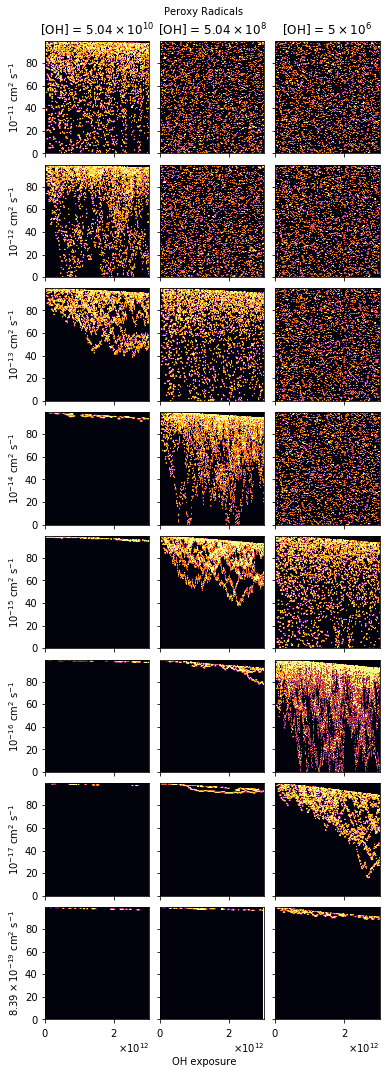

In [19]:
%matplotlib inline

# Set up color map levels

N_levels = 26
  
levels = np.linspace(0, 1, num=26)
labels = np.linspace(0, 1, num=6)
    
fig, axes = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(6, 18))

plt.figtext(0.4, 0.90, "Peroxy Radicals")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.figtext(0.42, 0.09, "OH exposure")



i = 0
for cond in condition:
    j = 0
    for D in diffusion["ft"]:
        data = Peroxy_contours[cond+"_"+D]
        axes[j, i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap='inferno')
        axes[j, i].xaxis.label.set_visible(False)
        axes[j, i].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True, useOffset=False))
        if j == 0:
            axes[j, i].set_title(cond_string_conv[cond])
        if i == 0:
            axes[j, i].set_ylabel(D_string_format[D]+r" cm$^2$ s$^{-1}$")
        j += 1
    i += 1
    
axes[0,0].set_xlim([0,3.02E12])

fig.savefig(os.path.join(subdir, 'peroxy_contours.png'),
            fmt='png', dpi=300, bbox_inches='tight')